# Рекомендателная система для музыки

Дaтасет:
https://www.kaggle.com/c/kkbox-music-recommendation-challenge/overview

Можете мерять результат по 5-fold evaluation на train-set,  per user auc roc.  

**Задача 1:**

Собрать более-менее приличную рекомендательную систему с помощью GBDT. Использование трюков из лекции (и не из неё), тюнинг и разумных объемов фича инжиниринг прям нужен. 

**Задача 2:**

Пользуясь информацией о треках построить неклассические эмбеддинги и попробовать использовать их:

a) показать симилары глазами

b) в качестве рекоммендера вместо GBDT (разницу в метриках) 

c) стек с GBDT (прирост / отсутствие / почему / SHAP values)

**Soft deadline:** 20.11

**Hard deadline:** 27.11

In [ ]:
!pip -q install catboost
!pip -q install shap

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
from numpy.linalg import norm

from tqdm.notebook import tqdm
from tqdm import trange
import multiprocessing
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv
from gensim.models import Word2Vec
import shap

import warnings 
warnings.filterwarnings('ignore') 

## Data loading

In [ ]:
! pip -q install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir data
% cd data
! kaggle competitions download -c kkbox-music-recommendation-challenge
!7z x train.csv.7z
!7z x test.csv.7z
!7z x songs.csv.7z
!7z x song_extra_info.csv.7z
!7z x members.csv.7z
!7z x sample_submission.csv.7z
!rm *.7z
% cd ..

## Data exploring and processing

В этой секции будет feature engineering, очистка датасета, заполнение пропусков, объединение датафреймов.

In [ ]:
data_path = './data'
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
# test = pd.read_csv(os.path.join(data_path, 'test.csv')) # не понадобится, так как без разметки
songs = pd.read_csv(os.path.join(data_path, 'songs.csv'))
songs_info = pd.read_csv(os.path.join(data_path, 'song_extra_info.csv'))
members = pd.read_csv(os.path.join(data_path, 'members.csv'))

In [ ]:
print('train df shape:', train.shape)
print('songs df shape:', songs.shape)
print('songs info df shape:', songs_info.shape)
print('members df shape:', members.shape)

train df shape: (7377418, 6)
songs df shape: (2296320, 7)
songs info df shape: (2295971, 3)
members df shape: (34403, 7)


In [ ]:
def nan_info(df):
    nans = []
    for col in df.columns:
        nans.append([col, df[col].isna().sum() / len(df[col]) * 100])
    return pd.DataFrame(nans, columns=['column', '% nans'])

### train

In [ ]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [ ]:
train.target = train.target.astype(np.uint8)
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             category
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              uint8   
dtypes: category(5), uint8(1)
memory usage: 84.6 MB


In [ ]:
nan_info(train)

,column,% nans
0,msno,0.000000
1,song_id,0.000000
2,source_system_tab,0.336825
3,source_screen_name,5.622618
4,source_type,0.291959
5,target,0.000000


In [ ]:
# нанов немного заменим их модой
cols = ['source_system_tab', 'source_screen_name', 'source_type']
for col in cols:
    train[col] = train[col].fillna(train[col].mode().values[0])

### songs

In [ ]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [ ]:
nan_info(songs)

,column,% nans
0,song_id,0.000000
1,song_length,0.000000
2,genre_ids,4.098558
3,artist_name,0.000000
4,composer,46.655257
5,lyricist,84.712409
6,language,0.000044


In [ ]:
# слишком много нанов в lyricist и composer
songs['lyricist'] = songs['lyricist'].fillna('UNK')
songs['composer'] = songs['composer'].fillna('UNK')
# заполним наны
songs['language'] = songs['language'].fillna(-1)
songs['genre_ids'] = songs['genre_ids'].fillna(songs['genre_ids'].mode().values[0])

songs.language = songs.language.astype(int)
for col in songs.columns:
    if songs[col].dtype == object:
        songs[col] = songs[col].astype('category')

In [ ]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype   
---  ------       -----   
 0   song_id      category
 1   song_length  int64   
 2   genre_ids    category
 3   artist_name  category
 4   composer     category
 5   lyricist     category
 6   language     int64   
dtypes: category(5), int64(2)
memory usage: 202.1 MB


### songs info

In [ ]:
songs_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [ ]:
songs_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   song_id  object
 1   name     object
 2   isrc     object
dtypes: object(3)
memory usage: 52.6+ MB


In [ ]:
nan_info(songs_info)

,column,% nans
0,song_id,0.000000
1,name,0.000087
2,isrc,5.947288


In [ ]:
# Достанем из isrc год
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

songs_info['song_year'] = songs_info['isrc'].apply(isrc_to_year)
songs_info = songs_info.drop(['isrc'], axis=1)

In [ ]:
# смёржим songs и songs_info, заполним наны
songs = songs.merge(songs_info, on="song_id", how='left')
songs['name'] = songs['name'].fillna('UNK')
songs['song_year'] = songs['song_year'].fillna(songs['song_year'].mode().values[0])
songs['song_year'] = songs['song_year'].astype(int)

for col in songs.columns:
    if songs[col].dtype == object:
        songs[col] = songs[col].astype('category')

Оставим в train и songs только те песни которые есть в обоих датафреймах от этого train уменьшится всего на 114 записей, а мёржить эти датафреймы всё равно будем по song_id

In [ ]:
song_ids = np.intersect1d(train['song_id'], songs['song_id'])
train = train[train['song_id'].isin(song_ids)]
songs = songs[songs['song_id'].isin(song_ids)]

In [ ]:
# добавим фичу счётчик прослушиваний

count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}

def count_played(x):
    return count_song_played_train[x]

train['song_played'] = train['song_id'].apply(lambda x: count_played(x))

In [ ]:
# смёржим train и songs
train = train.merge(songs, on="song_id", how='left')

In [ ]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_played,song_length,genre_ids,artist_name,composer,lyricist,language,name,song_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,215,206471,359,Bastille,Dan Smith| Mark Crew,UNK,52,Good Grief,2016
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,1,284584,1259,Various Artists,UNK,UNK,52,Lords of Cardboard,1999
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,4,225396,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,UNK,52,Hip Hop Is Dead(Album Version (Edited)),2006
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,1,255512,1019,Soundway,Kwadwo Donkoh,UNK,-1,Disco Africa,2010
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,412,187802,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,UNK,52,Sleep Without You,2016


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377304 entries, 0 to 7377303
Data columns (total 15 columns):
 #   Column              Dtype   
---  ------              -----   
 0   msno                category
 1   song_id             object  
 2   source_system_tab   category
 3   source_screen_name  category
 4   source_type         category
 5   target              uint8   
 6   song_played         int64   
 7   song_length         int64   
 8   genre_ids           category
 9   artist_name         category
 10  composer            category
 11  lyricist            category
 12  language            int64   
 13  name                category
 14  song_year           int64   
dtypes: category(9), int64(4), object(1), uint8(1)
memory usage: 587.1+ MB


In [ ]:
# у песен genre_ids, artist_name, composer, lyricist может быть несколько значений.
# Сделаем счётчики значений дополнительной фичёй

def get_cnt(col):
    cnt = len(col.split('|'))
    return cnt

train['genre_cnt'] = train.genre_ids.apply(get_cnt)
train['artist_cnt'] = train.artist_name.apply(get_cnt)
train['composer_cnt'] = train.composer.apply(get_cnt)
train['lyricist_cnt'] = train.lyricist.apply(get_cnt)

### members

In [ ]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [ ]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [ ]:
nan_info(members)

,column,% nans
0,msno,0.000000
1,city,0.000000
2,bd,0.000000
3,gender,57.849606
4,registered_via,0.000000
5,registration_init_time,0.000000
6,expiration_date,0.000000


In [ ]:
# примерно у половины пользователей не известен пол, введём доп. значение UNK
members['gender'] = members['gender'].fillna('UNK')

# достанем год регистрации
members['registration_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0: 4]))

# достанем год окончания подписки
members['expiration_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0: 4]))

# длительность подписки
expiration = members.expiration_year * 12 + members['expiration_date'].apply(lambda x: int(str(x)[4: 6]))
registration = members.registration_year * 12 + members['registration_init_time'].apply(lambda x: int(str(x)[4: 6]))
members['membership_month'] = expiration - registration

for col in members.columns:
    if members[col].dtype == object:
        members[col] = members[col].astype('category')

In [ ]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_year,expiration_year,membership_month
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,UNK,7,20110820,20170920,2011,2017,73
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,UNK,7,20150628,20170622,2015,2017,24
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,UNK,4,20160411,20170712,2016,2017,15
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,UNK,9,20150906,20150907,2015,2015,0
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,UNK,4,20170126,20170613,2017,2017,5


In [ ]:
# фича: активность пользователя

user_activity = {k:v for k,v in train['msno'].value_counts().iteritems()}
def count_user_activity(x):
    return user_activity[x]

train['user_activity'] = train['msno'].apply(lambda x: count_user_activity(x))

In [ ]:
# смёржим train и songs
train = train.merge(members, on="msno", how='left')

In [ ]:
# train = train.drop(['msno', 'song_id'], axis=1)
train = train.drop(['registration_init_time', 'expiration_date'], axis=1)

In [ ]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_played,song_length,genre_ids,artist_name,composer,lyricist,language,name,song_year,genre_cnt,artist_cnt,composer_cnt,lyricist_cnt,user_activity,city,bd,gender,registered_via,registration_year,expiration_year,membership_month
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,215,206471,359,Bastille,Dan Smith| Mark Crew,UNK,52,Good Grief,2016,1,1,2,1,5511,1,0,UNK,7,2012,2017,69
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,1,284584,1259,Various Artists,UNK,UNK,52,Lords of Cardboard,1999,1,1,1,1,622,13,24,female,9,2011,2017,76
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,4,225396,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,UNK,52,Hip Hop Is Dead(Album Version (Edited)),2006,1,1,1,1,622,13,24,female,9,2011,2017,76
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,1,255512,1019,Soundway,Kwadwo Donkoh,UNK,-1,Disco Africa,2010,1,1,1,1,622,13,24,female,9,2011,2017,76
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,412,187802,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,UNK,52,Sleep Without You,2016,1,1,3,1,5511,1,0,UNK,7,2012,2017,69


In [ ]:
# Note: bd column has outlier values.

# есть отрицательные значения
# есть слишком большие и маленькие значения

mask1 = train.bd < 0
train.bd[mask1] = -train.bd[mask1]

mask2 = (train.bd > 5) & (train.bd < 95)
age_mode = train.bd[mask2].mode()
train.bd[~mask2] = age_mode

train['bd'] = train['bd'].fillna(train['bd'].mode().values[0])
train['bd'] = train['bd'].astype(int)

## Задача 1: GBDT

In [ ]:
X = train.copy()
X = X.drop(['song_id', 'msno', 'target', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'name'], axis=1)
y = train.target

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377304 entries, 0 to 7377303
Data columns (total 19 columns):
 #   Column              Dtype   
---  ------              -----   
 0   source_system_tab   category
 1   source_screen_name  category
 2   source_type         category
 3   song_played         int64   
 4   song_length         int64   
 5   language            int64   
 6   song_year           int64   
 7   genre_cnt           int64   
 8   artist_cnt          int64   
 9   composer_cnt        int64   
 10  lyricist_cnt        int64   
 11  user_activity       int64   
 12  city                int64   
 13  bd                  int64   
 14  gender              category
 15  registered_via      int64   
 16  registration_year   int64   
 17  expiration_year     int64   
 18  membership_month    int64   
dtypes: category(4), int64(15)
memory usage: 1.2 GB


Категориальные фичи: `gender`, `city`, `language`, `source_type`, `source_screen_name`, `source_system_tab`

In [ ]:
categorical = [0, 1, 2, 3, 5, 12, 14]
pool = Pool(data=X, label=y, cat_features=categorical, has_header=True)

params = {'loss_function': 'Logloss',
          'custom_loss': 'AUC',
          'iterations': 50}

model = CatBoostClassifier(**params)

# проведём гридсёрч по паре параметров
param_grid = {'learning_rate': [0.01, 0.1, 0.5],
              'depth':[5, 10],}

grid_search_info = model.grid_search(param_grid,
                                     pool,
                                     cv=5,
                                     calc_cv_statistics=True,
                                     search_by_train_test_split=True,
                                     train_size=0.7,
                                     verbose=False,
                                     )


0:	learn: 0.6922862	test: 0.6922883	best: 0.6922883 (0)	total: 5.31s	remaining: 4m 20s
1:	learn: 0.6914552	test: 0.6914610	best: 0.6914610 (1)	total: 9.83s	remaining: 3m 56s
2:	learn: 0.6906264	test: 0.6906345	best: 0.6906345 (2)	total: 14.7s	remaining: 3m 49s
3:	learn: 0.6898242	test: 0.6898341	best: 0.6898341 (3)	total: 18.8s	remaining: 3m 36s
4:	learn: 0.6890383	test: 0.6890499	best: 0.6890499 (4)	total: 23s	remaining: 3m 27s
5:	learn: 0.6882609	test: 0.6882738	best: 0.6882738 (5)	total: 27.7s	remaining: 3m 23s
6:	learn: 0.6874957	test: 0.6875107	best: 0.6875107 (6)	total: 31.6s	remaining: 3m 14s
7:	learn: 0.6867538	test: 0.6867714	best: 0.6867714 (7)	total: 35.6s	remaining: 3m 7s
8:	learn: 0.6860332	test: 0.6860527	best: 0.6860527 (8)	total: 39.7s	remaining: 3m
9:	learn: 0.6853199	test: 0.6853409	best: 0.6853409 (9)	total: 43.6s	remaining: 2m 54s
10:	learn: 0.6846148	test: 0.6846378	best: 0.6846378 (10)	total: 47.7s	remaining: 2m 49s
11:	learn: 0.6839287	test: 0.6839530	best: 0.683

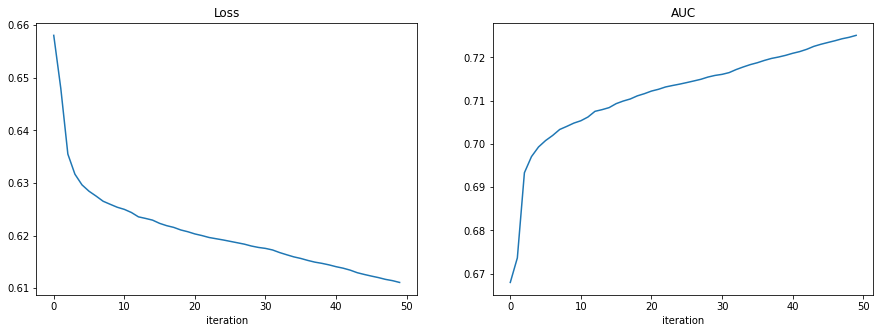

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))

loss = grid_search_info['cv_results']['test-Logloss-mean']
metric = grid_search_info['cv_results']['test-AUC-mean']
ax1.plot(loss)
ax1.set_title('Loss')
ax1.set_xlabel('iteration')

ax2.plot(metric)
ax2.set_title('AUC')
ax2.set_xlabel('iteration')


plt.show()

In [ ]:
print('AUC:', grid_search_info['cv_results']['test-AUC-mean'][-1])

AUC: 0.7250916018867861


In [ ]:
pd.DataFrame(grid_search_info['cv_results']).head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.658080,0.000186,0.658054,0.000181,0.667984,0.000537
1,1,0.647986,0.000252,0.647903,0.000214,0.673656,0.000575
2,2,0.635502,0.000236,0.635559,0.000176,0.693337,0.000494
3,3,0.631683,0.000295,0.631861,0.000187,0.697063,0.000514
4,4,0.629655,0.000226,0.629893,0.000257,0.699294,0.000446


In [ ]:
pd.DataFrame(grid_search_info['cv_results']).tail()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
45,45,0.612306,0.000265,0.611310,0.000211,0.723443,0.000437
46,46,0.612019,0.000530,0.611002,0.000382,0.723849,0.000794
47,47,0.611681,0.000554,0.610635,0.000431,0.724301,0.000806
48,48,0.611435,0.000566,0.610366,0.000481,0.724640,0.000795
49,49,0.611097,0.000604,0.609977,0.000510,0.725092,0.000871


In [ ]:
# лучшие параметры
grid_search_info['params']

{'depth': 10, 'learning_rate': 0.5}

Будем обучать модель 100 эпох с найденными параметрами.

In [ ]:
best_params = {'loss_function': 'Logloss',
               'custom_loss': 'AUC',
               'iterations': 100,
               'depth': 10,
               'learning_rate': 0.5}

cv_results, ms = cv(pool=pool,
                    params=best_params,
                    fold_count=5,
                    return_models=True)

Training on fold [0/5]
0:	learn: 0.6578810	test: 0.6582329	best: 0.6582329 (0)	total: 9.35s	remaining: 15m 25s
1:	learn: 0.6477341	test: 0.6481842	best: 0.6481842 (1)	total: 17.8s	remaining: 14m 33s
2:	learn: 0.6353572	test: 0.6356801	best: 0.6356801 (2)	total: 26s	remaining: 14m
3:	learn: 0.6316442	test: 0.6318700	best: 0.6318700 (3)	total: 34.1s	remaining: 13m 38s
4:	learn: 0.6294561	test: 0.6295756	best: 0.6295756 (4)	total: 42.4s	remaining: 13m 25s
5:	learn: 0.6283497	test: 0.6284846	best: 0.6284846 (5)	total: 50.2s	remaining: 13m 6s
6:	learn: 0.6273820	test: 0.6275058	best: 0.6275058 (6)	total: 58.2s	remaining: 12m 53s
7:	learn: 0.6266380	test: 0.6268193	best: 0.6268193 (7)	total: 1m 6s	remaining: 12m 41s
8:	learn: 0.6258761	test: 0.6261400	best: 0.6261400 (8)	total: 1m 14s	remaining: 12m 33s
9:	learn: 0.6252810	test: 0.6255848	best: 0.6255848 (9)	total: 1m 22s	remaining: 12m 21s
10:	learn: 0.6248131	test: 0.6251469	best: 0.6251469 (10)	total: 1m 30s	remaining: 12m 13s
11:	learn: 

In [ ]:
cv_results.tail(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
90,90,0.601761,0.000503,0.599627,0.000368,0.737236,0.000653
91,91,0.601648,0.000497,0.599473,0.000401,0.737375,0.000636
92,92,0.601469,0.000510,0.599255,0.000357,0.737609,0.000677
93,93,0.601310,0.000435,0.599065,0.000302,0.737815,0.000575
94,94,0.601129,0.000509,0.598861,0.000341,0.738044,0.000671
95,95,0.600951,0.000551,0.598663,0.000310,0.738266,0.000737
96,96,0.600778,0.000546,0.598480,0.000351,0.738487,0.000718
97,97,0.600555,0.000503,0.598220,0.000375,0.738750,0.000652
98,98,0.600340,0.000444,0.597987,0.000388,0.739026,0.000569
99,99,0.600164,0.000400,0.597792,0.000404,0.739245,0.000494


Можно заметить, что для фолдов стандартное отклонение лосса и AUCа довольно низкое, а значит сильного разброса нет. На тесте модель достигает AUC около 0.73.

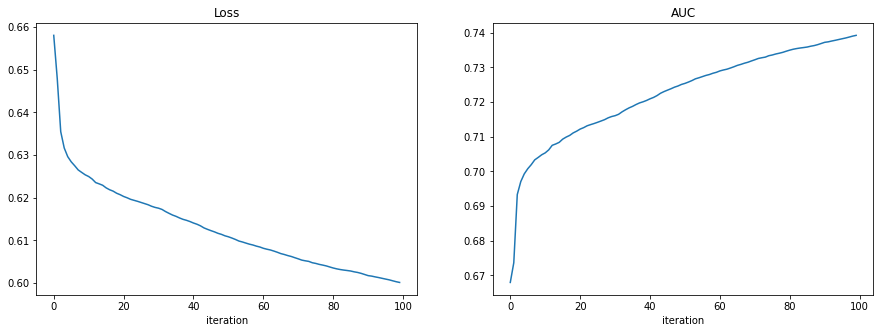

AUC: 0.7392452144698342


In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))

loss = cv_results['test-Logloss-mean']
metric = cv_results['test-AUC-mean']
ax1.plot(loss)
ax1.set_title('Loss')
ax1.set_xlabel('iteration')

ax2.plot(metric)
ax2.set_title('AUC')
ax2.set_xlabel('iteration')


plt.show()

print('AUC:', cv_results['test-AUC-mean'].iloc[-1])

Исходя из графика, я бы предположил, что обучать можно дольше 100 эпох. Но так как чтобы обучить даже 100 эпох у меня уходило много времени, я не стал экспериментировать с количеством эпох.

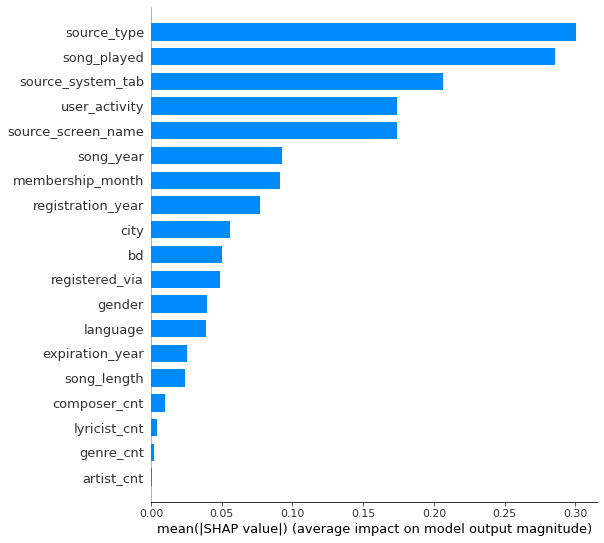

In [ ]:
# интерпретация
interpret_idxs = np.random.choice(X.index, 1000, replace=False)
X_interpret = X.iloc[interpret_idxs]
explainer = shap.TreeExplainer(ms[0])
shap_values = explainer.shap_values(X_interpret)
shap.summary_plot(shap_values, X_interpret, plot_type="bar")

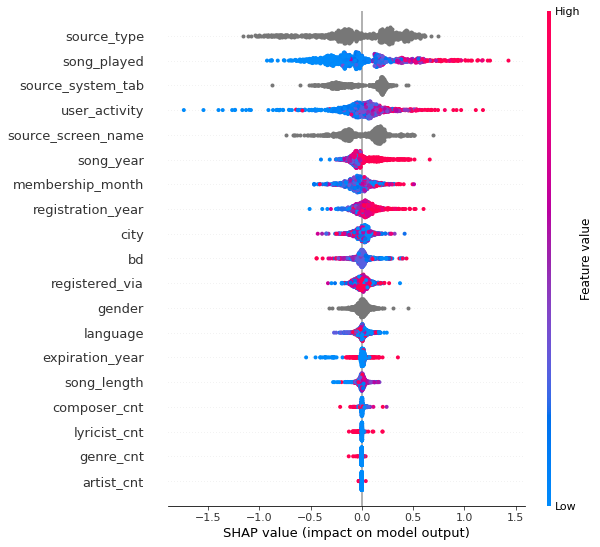

In [ ]:
shap.summary_plot(shap_values, X_interpret)

Исходя из графика наибольший вклад внесли `source_type`, `song_played`. Также немаловажными оказались фичи `source_system_tab`, `user_activity`, `source_screen_name`. То есть и популярность песни и активность пользователя в целом, а также некоторые внутренние характеристики приложения/сайта/сервиса.

## Задача 2: unclassical embeddings

Тут я решил использовать word-to-vec модель. Обучал её на строках вида "artist - song". Таким образом, для песен из датасета были получены векторные представления (размерности 64).

In [ ]:
emb_size = 64
w2v_train = train[['msno', 'song_id', 'target','artist_name', 'name']]

In [ ]:
# группируем данные для обучения w2v

users = np.unique(w2v_train['msno'])
user_items = defaultdict(list)

for row in tqdm(w2v_train.iterrows(), total=len(w2v_train)):
    row = row[1]
    user = row['msno']
    artist = row['artist_name']
    song = row['name']
    user_items[user].append(f'{artist} - {song}')
corpus = list(user_items.values())

# инициализация и обучение w2v
w2v = Word2Vec(window=10, size=emb_size, negative=15, sg=1, hs=0, alpha=0.03,
               min_alpha=0.0007, workers=multiprocessing.cpu_count())
w2v.build_vocab(corpus)
w2v.train(corpus, total_examples=w2v.corpus_count, epochs=15)
w2v.init_sims(replace=True)

  0%|          | 0/7377304 [00:00<?, ?it/s]

(105404355, 110659560)

### a) similars

In [ ]:
song_list = list(w2v.wv.vocab.items())

def random_example(k=5):
    idx = np.random.randint(len(song_list))
    query = song_list[idx][0]
    print("QUERY:", query)
    print("SIMILARS:")
    similars = w2v.similar_by_vector(w2v[query], topn=k+1)[1:]
    return similars

In [ ]:
random_example()

QUERY: The Weeknd - Starboy
SIMILARS:


[('Clean Bandit - Rockabye', 0.8957654237747192),
 ('Mike Posner - I Took A Pill In Ibiza', 0.8940248489379883),
 ('Fifth Harmony - Work from Home', 0.88713139295578),
 ('Justin Timberlake - CAN\'T STOP THE FEELING! (Original Song from DreamWorks Animation\'s "TROLLS")',
  0.8845698833465576),
 ('ZAYN| Taylor Swift - I Don’t Wanna Live Forever (Fifty Shades Darker)',
  0.8843075037002563)]

In [ ]:
random_example()

QUERY: Relax α Wave - Let It Go
SIMILARS:


[('Relax α Wave - Once Upon a Dream', 0.8673030138015747),
 ('Relax α Wave - Part of Your World', 0.8428133726119995),
 ('Relax α Wave - Beauty and the Beast', 0.8156678676605225),
 ('Relax α Wave - Colors of the Wind', 0.7888686060905457),
 ('Relax α Wave - When You Wish Upon a Star', 0.7829329371452332)]

In [ ]:
random_example()

QUERY: Boys Noize - Inhale / Exhale
SIMILARS:


[('Bonobo - First Fires', 0.7060795426368713),
 ('Vindata - Spirals', 0.6870056986808777),
 ('Breakbot - One Out Of Two (feat. Irfane)', 0.6770935654640198),
 ('D/R/U/G/S feat. Akiine - New Born Love', 0.6698501706123352),
 ('Andain - Turn Up the Sound (Tristan Garner Remix)', 0.6689170598983765)]

In [ ]:
random_example()

QUERY: BIRDY - All You Never Say
SIMILARS:


[('BIRDY - Words As Weapons', 0.7521324157714844),
 ('BIRDY - Wild Horses', 0.7169698476791382),
 ('BIRDY - Wings', 0.7073356509208679),
 ('BIRDY - No Angel', 0.700459897518158),
 ('BIRDY - Skinny Love', 0.6975072026252747)]

In [ ]:
random_example()

QUERY: IL DIVO - Regresa A Mi
SIMILARS:


[('Celine Dion - Right In Front Of You', 0.7568114399909973),
 ('IL DIVO - Time to Say Goodbye (Con Te Partirò)', 0.7553979754447937),
 ('IL DIVO - Ti Amero', 0.7525670528411865),
 ('Sting - Mad About You', 0.7388925552368164),
 ('IL DIVO - Heroe(英雄)', 0.7303694486618042)]

In [ ]:
random_example(10)

QUERY: Michael Bolton - How Am I Supposed to Live Without You
SIMILARS:


[('Air Supply - Here I Am (Just When I Thought I Was Over You)(有我在此)',
  0.704836368560791),
 ('Paul Anka - Put Your Head On My Shoulder', 0.7016338109970093),
 ('70s Love - Baby Come Back', 0.7014877796173096),
 ('Roxette - It Must Have Been Love', 0.6995276808738708),
 ('Gerard Joling - Ticket To The Tropics', 0.6958640813827515),
 ('Daughtry - Life After You', 0.6835019588470459),
 ('Taylor Dayne - Love Will Lead You Back', 0.6787685751914978),
 ('Heart - These Dreams', 0.6744419932365417),
 ('Elton John - Can You Feel The Love Tonight', 0.6736887097358704),
 ('Chicago - Hard Habit To Break', 0.6692962646484375)]

In [ ]:
random_example(10)

QUERY: Bryan Adams - I'll Always Be Right There
SIMILARS:


[('Bryan Adams - Straight From The Heart', 0.7163077592849731),
 ('Bryan Adams - Please Forgive Me', 0.6980815529823303),
 ('Paolo Nutini - New Shoes (Album Version)', 0.6929312348365784),
 ('Eagles - Doolin-Dalton', 0.6894090175628662),
 ("Bryan Adams - Summer Of '69", 0.6784887313842773),
 ('Bryan Adams - She Knows Me', 0.6782256960868835),
 ("Eagles - Lyin' Eyes", 0.6776796579360962),
 ('Eagles - Life In The Fast Lane', 0.6747273206710815),
 ('Eagles - Business ACenter Of The Universes Usual', 0.6679564118385315),
 ('Bee Gees - Spicks and Specks', 0.6669367551803589)]

In [ ]:
random_example(10)

QUERY: Taking Back Sunday - Tidal Wave
SIMILARS:


[('Sum 41 - God Save Us All (Death to POP)', 0.6915134191513062),
 ('Bastille - Glory', 0.6864012479782104),
 ('twenty one pilots - Cancer', 0.6734537482261658),
 ('Green Day - Youngblood', 0.6721490025520325),
 ('TWO DOOR CINEMA CLUB - Gameshow', 0.6660529375076294),
 ('Green Day - Ordinary World', 0.6576299667358398),
 ("Coldplay - Don't Panic", 0.6556333303451538),
 ('Ed Sheeran - Little Bird', 0.6529711484909058),
 ('Agnes Obel - Golden Green', 0.6495360136032104),
 ('We The Kings - Sad Song (feat. Elena Coats)', 0.6461539268493652)]

Кажется, симилары выглядят неплохо. Это либо песни того же исполнителя, либо что-то похожее.

### b) recommender = w2v, сравнение с GBDT

Чтобы использовать w2v в качестве рекомендательной системы, необходимо иметь эмбединг пользователя. Для этого будем усреднять эмбеддинги прослушенных пользователем песен (с таргет = 1).

In [ ]:
# разобъём данные
w2v_train = train[['msno', 'song_id', 'target','artist_name', 'name']]
w2v_train, w2v_val = train_test_split(w2v_train, test_size = 0.3, stratify=train.target)

In [ ]:
def create_user_embeddings(model, df):
    users = np.unique(df.msno)
    user_embeddings = defaultdict(lambda: np.zeros(emb_size))
    user_counts = defaultdict(lambda: 1e-8)
    for row in tqdm(df.iterrows(), total=len(df)):
        row = row[1]
        song_name = row['name']
        artist = row['artist_name']
        user_id = row['msno']
        input_model = artist + ' - ' + song_name
        if row['target'] == 1:
            if input_model in model:
                user_embeddings[user_id] += model[input_model]

    for user_id in user_embeddings.keys():
        user_embeddings[user_id] /= user_counts[user_id]

    return user_embeddings

In [ ]:
user_embeddings = create_user_embeddings(w2v, w2v_train)

In [ ]:
# оценим w2v рекомендательную систему

y_true = []
y_pred_prob = []
for row in tqdm(w2v_val.iterrows(), total=len(w2v_val)):
    row = row[1]
    song_name = row['name']
    artist = row['artist_name']
    user_id = row['msno']
    target = row['target']
    input_model = artist + ' - ' + song_name
    
    if input_model in w2v:
        item_embedding = w2v[input_model]
    else:
        item_embedding = np.zeros(emb_size)
    item_embedding = item_embedding / (norm(item_embedding) + 1e-8)
    user_embedding = user_embeddings[user_id]
    user_embedding = user_embedding / (norm(user_embedding) + 1e-8)
    sim = item_embedding @ user_embedding
    y_pred_prob.append(sim)
    y_true.append(target)

from sklearn.metrics import roc_auc_score
print('AUC:', roc_auc_score(y_true, y_pred_prob))

In [ ]:
# оценим w2v рек сис:
from numpy.linalg import norm
y_true = []
y_pred_prob = []
for row in tqdm(w2v_val.iterrows(), total=len(w2v_val)):
    row = row[1]
    song_name = row['name']
    artist = row['artist_name']
    user_id = row['msno']
    target = row['target']
    input_model = artist + ' - ' + song_name
    
    if input_model in w2v:
        item_embedding = w2v[input_model]
    else:
        item_embedding = np.zeros(emb_size)
    item_embedding = item_embedding / (norm(item_embedding) + 1e-8)
    user_embedding = user_embeddings[user_id]
    user_embedding = user_embedding / (norm(user_embedding) + 1e-8)
    sim = item_embedding @ user_embedding
    y_pred_prob.append(sim)
    y_true.append(target)

from sklearn.metrics import roc_auc_score
print('AUC:', roc_auc_score(y_true, y_pred_prob))

  0%|          | 0/2213192 [00:00<?, ?it/s]

AUC: 0.7117799097315372


AUC оказался немного ниже, чем в задаче 1 (0.73). Но, кажется, что получить такой результат только по названиям довольно неплохо. 

Можно ещё просто посмотреть как выглядят рекомендации для случайного пользователя.

In [ ]:
users = np.unique(w2v_val.msno)

def recommend(model, users, user_embeddings, k=5):
    idx = np.random.randint(len(users))
    user = users[idx]
    user_emb = user_embeddings[user]

    print("RECOMMENDATIONS:")
    recommendations = model.similar_by_vector(user_emb, topn=k)
    return recommendations

In [ ]:
recommend(w2v, users, user_embeddings, k=5)

RECOMMENDATIONS:


[('Fifth Harmony - Work from Home', 0.7260327339172363),
 ('Fifth Harmony - Worth It', 0.7232092022895813),
 ('Justin Timberlake - CAN\'T STOP THE FEELING! (Original Song from DreamWorks Animation\'s "TROLLS")',
  0.7229118347167969),
 ('twenty one pilots - Heathens', 0.7211467027664185),
 ('The Chainsmokers - Closer', 0.7207790017127991)]

In [ ]:
recommend(w2v, users, user_embeddings, k=5)

RECOMMENDATIONS:


[('Bruno Mars - Versace On The Floor', 0.8474882245063782),
 ('The Weeknd - Party Monster', 0.8354108333587646),
 ('Robin Schulz & David Guetta - Shed A Light', 0.8248117566108704),
 ('John Legend - Love Me Now', 0.7971640825271606),
 ('The xx - On Hold', 0.7817398309707642)]

In [ ]:
recommend(w2v, users, user_embeddings, k=5)

RECOMMENDATIONS:


[('Crush - Beautiful', 0.7811492085456848),
 ('Sam Kim - Who are you', 0.7754925489425659),
 ('Alan Walker - Alone', 0.7754560112953186),
 ('Eddy Kim - You are so beautiful', 0.7752922773361206),
 ('EXO CHANYEOL & PUNCH - Stay With Me', 0.7728744149208069)]

In [ ]:
recommend(w2v, users, user_embeddings, k=5)

RECOMMENDATIONS:


[('Imagine Dragons - Demons (電影「跨越世紀的情書」預告曲、美國職棒大聯盟一週好球)', 0.8038269281387329),
 ('OneRepublic - Counting Stars', 0.7920511364936829),
 ('Carly Rae Jepsen - I Really Like You', 0.7893536686897278),
 ('Rixton - Me And My Broken Heart', 0.785542368888855),
 ('Colbie Caillat - Try', 0.7789655923843384)]

In [ ]:
recommend(w2v, users, user_embeddings, k=5)

RECOMMENDATIONS:


[('The Chainsmokers - Closer', 0.7427272200584412),
 ('Carly Rae Jepsen - I Really Like You', 0.7390003204345703),
 ("CHARLIE PUTH - We Don't Talk Anymore", 0.7381795048713684),
 ('Justin Timberlake - CAN\'T STOP THE FEELING! (Original Song from DreamWorks Animation\'s "TROLLS")',
  0.7379060983657837),
 ('Alan Walker - Alone', 0.7368127107620239)]

### c) w2v + GBDT, сравнение с GBDT

На всём датасете обучение длится очень большое количество времени, поэтому я решил в этом пункте поработать с частью датасета.

In [ ]:
train = train[:1000000]
train, val = train_test_split(train, test_size=0.3, stratify=train.target)

Сначала сформируем train/val выборки для двух случаев:

- без w2v фичей (как в задаче 1)

- вместе с w2v фичами

In [ ]:
# train sets creating
w2v_train = train[['msno', 'song_id', 'target','artist_name', 'name']]
song_embs = []
cnt = 0
for row in tqdm(w2v_train.iterrows(), total=len(w2v_train)):
    row = row[1]
    user = row['msno']
    artist = row['artist_name']
    song = row['name']
    item = f'{artist} - {song}'
    if item in w2v:
        song_emb = w2v[item]
    else:
        song_emb = np.zeros(emb_size)
        cnt += 1

    song_embs.append(song_emb)

song_embs_train = pd.DataFrame(song_embs)

# на этом обучается бустинг в задаче 1
X_train = train.drop(['song_id', 'msno', 'target', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'name'], axis=1) # gbdt
X_train_new = X_train.join(song_embs_train) # для w2v + gbdt

y_train = train.target

  0%|          | 0/700000 [00:00<?, ?it/s]

In [ ]:
# val sets creating
w2v_val = val[['msno', 'song_id', 'target','artist_name', 'name']]

song_embs = []
cnt = 0
for row in tqdm(w2v_val.iterrows(), total=len(w2v_val)):
    row = row[1]
    user = row['msno']
    artist = row['artist_name']
    song = row['name']
    item = f'{artist} - {song}'
    if item in w2v:
        song_emb = w2v[item]
    else:
        song_emb = np.zeros(emb_size)
        cnt += 1

    song_embs.append(song_emb)

song_embs_val = pd.DataFrame(song_embs)

# на этом обучается бустинг в задаче 1
X_val = val.drop(['song_id', 'msno', 'target', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'name'], axis=1) # gbdt
X_val_new = X_val.join(song_embs_val) # для w2v + gbdt

y_val = val.target

  0%|          | 0/300000 [00:00<?, ?it/s]

Переходим к обучению моделей и сравнению результатов.

#### gbdt

In [ ]:
# обучаем бустинг (как в задаче 1)
categorical = [0, 1, 2, 3, 5, 12, 14]
pool = Pool(data=X_train, label=y_train, cat_features=categorical, has_header=True)
best_params = {'loss_function': 'Logloss',
               'custom_loss': 'AUC',
               'iterations': 100,
               'depth': 15,
               'learning_rate': 0.5}

model = CatBoostClassifier(**best_params)
model.fit(pool)

0:	learn: 0.5956592	total: 509ms	remaining: 50.3s
1:	learn: 0.5558174	total: 2.48s	remaining: 2m 1s
2:	learn: 0.5372403	total: 4.29s	remaining: 2m 18s
3:	learn: 0.5223151	total: 6.14s	remaining: 2m 27s
4:	learn: 0.5131897	total: 7.92s	remaining: 2m 30s
5:	learn: 0.5076434	total: 9.68s	remaining: 2m 31s
6:	learn: 0.5027803	total: 11.4s	remaining: 2m 31s
7:	learn: 0.4978593	total: 13.2s	remaining: 2m 31s
8:	learn: 0.4935727	total: 15s	remaining: 2m 31s
9:	learn: 0.4911514	total: 16.7s	remaining: 2m 30s
10:	learn: 0.4879203	total: 18.5s	remaining: 2m 29s
11:	learn: 0.4834192	total: 20.3s	remaining: 2m 28s
12:	learn: 0.4812929	total: 22.1s	remaining: 2m 28s
13:	learn: 0.4755330	total: 23.9s	remaining: 2m 26s
14:	learn: 0.4737948	total: 25.6s	remaining: 2m 25s
15:	learn: 0.4715549	total: 27.4s	remaining: 2m 23s
16:	learn: 0.4696272	total: 29.1s	remaining: 2m 22s
17:	learn: 0.4678543	total: 30.9s	remaining: 2m 20s
18:	learn: 0.4658908	total: 32.6s	remaining: 2m 19s
19:	learn: 0.4638516	total

In [ ]:
# оценка качества
y_pred_probs = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_probs)

0.8437636222106089

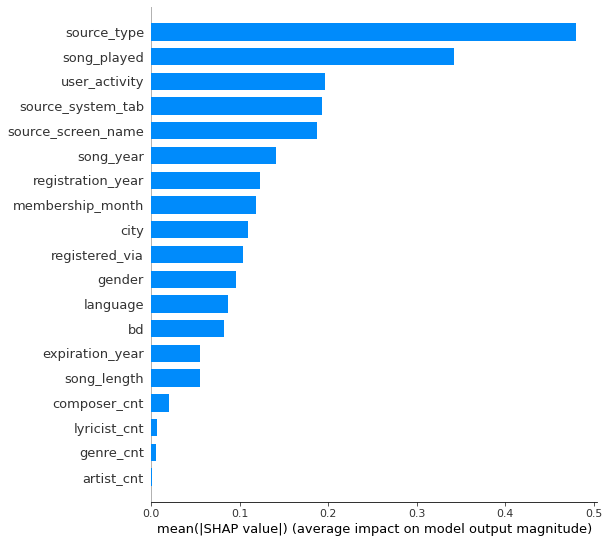

In [ ]:
# интерпретация
interpret_idxs = np.random.choice(X_val.reset_index().index, 100, replace=False)
X_interpret = X_val.iloc[interpret_idxs]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_interpret)
shap.summary_plot(shap_values, X_interpret, plot_type="bar")

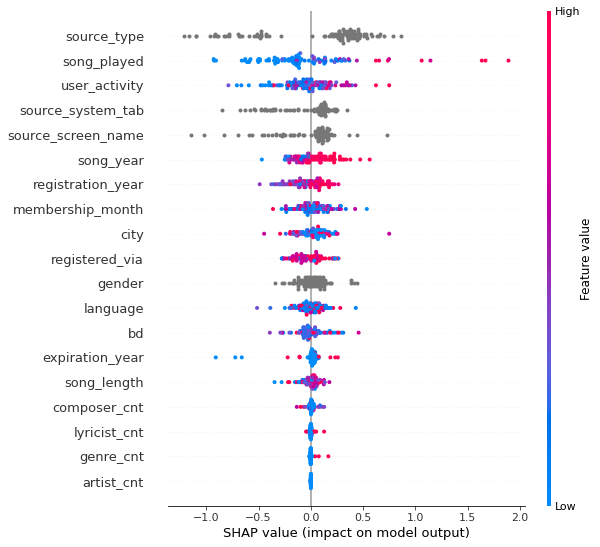

In [ ]:
shap.summary_plot(shap_values, X_interpret)

#### w2v + gbdt

In [ ]:
# обучаем новый бустинг (в данных есть неклассические эмбеддинги)

categorical = [0, 1, 2, 3, 5, 12, 14]
pool = Pool(data=X_train_new, label=y_train, cat_features=categorical, has_header=True)
best_params = {'loss_function': 'Logloss',
               'custom_loss': 'AUC',
               'iterations': 100,
               'depth': 15,
               'learning_rate': 0.5}

model = CatBoostClassifier(**best_params)
model.fit(pool)

0:	learn: 0.5772095	total: 14.7s	remaining: 24m 15s
1:	learn: 0.5347163	total: 29.7s	remaining: 24m 13s
2:	learn: 0.5134709	total: 44.4s	remaining: 23m 54s
3:	learn: 0.5050093	total: 58.6s	remaining: 23m 27s
4:	learn: 0.4985674	total: 1m 12s	remaining: 23m 6s
5:	learn: 0.4921292	total: 1m 27s	remaining: 22m 51s
6:	learn: 0.4843795	total: 1m 42s	remaining: 22m 38s
7:	learn: 0.4754058	total: 1m 57s	remaining: 22m 25s
8:	learn: 0.4700538	total: 2m 11s	remaining: 22m 13s
9:	learn: 0.4660177	total: 2m 26s	remaining: 21m 56s
10:	learn: 0.4620012	total: 2m 40s	remaining: 21m 40s
11:	learn: 0.4590530	total: 2m 55s	remaining: 21m 25s
12:	learn: 0.4536543	total: 3m 9s	remaining: 21m 10s
13:	learn: 0.4487041	total: 3m 24s	remaining: 20m 54s
14:	learn: 0.4459837	total: 3m 38s	remaining: 20m 39s
15:	learn: 0.4371201	total: 3m 54s	remaining: 20m 29s
16:	learn: 0.4353295	total: 4m 8s	remaining: 20m 12s
17:	learn: 0.4315738	total: 4m 23s	remaining: 20m
18:	learn: 0.4261082	total: 4m 38s	remaining: 19m

In [ ]:
# оценка качества
y_pred_probs = model.predict_proba(X_val_new)[:, 1]
roc_auc_score(y_val, y_pred_probs)

0.7952480682224188

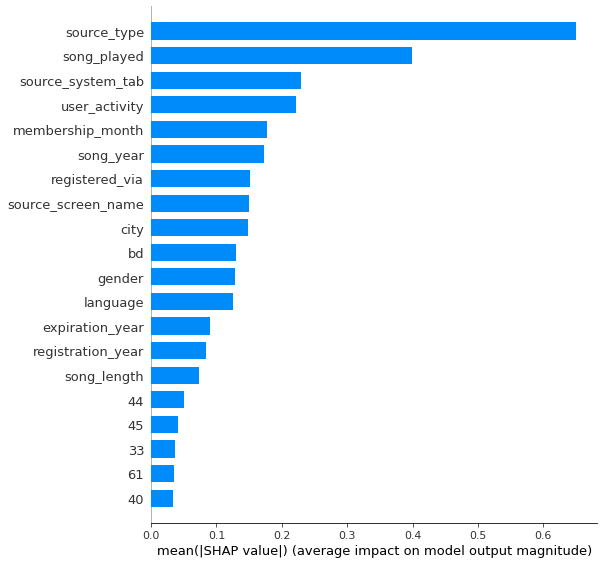

In [ ]:
# интерпретация
interpret_idxs = np.random.choice(X_val_new.reset_index().index, 100, replace=False)
X_interpret = X_val_new.iloc[interpret_idxs]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_interpret)
shap.summary_plot(shap_values, X_interpret, plot_type="bar")

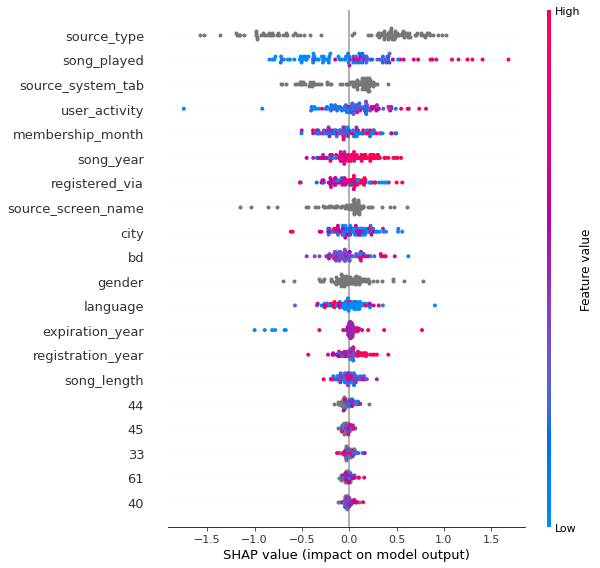

In [ ]:
shap.summary_plot(shap_values, X_interpret)

#### итог

В результате чистый gbdt показал лучший результат (0.84 в сравнении с 0.79), при том что обучение второй модели заняло в разы больше времени из-за большого числа фичей. Расклад важности фичей изменился не сильно (во второй модели 5 компонент из 64 вышли в топ-20). 

В дополнение к этому: мне поздно пришла идея использовать не эмбединги песен как дополнительные фичи, а некоторое аккумулированное значение (например, скалярное произведение эмбедингов пользователя и песни). Это во первых облегчило бы обучение и, возможно, принесло улучшение. Но обучить такую модель я не успевал.